<a href="https://colab.research.google.com/github/GitGreg228/sepmp_ml_2023/blob/main/seminars/seminar_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from google.colab.patches import cv2_imshow
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

ROWS = 64
COLS = 64
CHANNELS = 3

In [ ]:
digits = load_digits()

In [ ]:
X = digits.data
y = digits.target

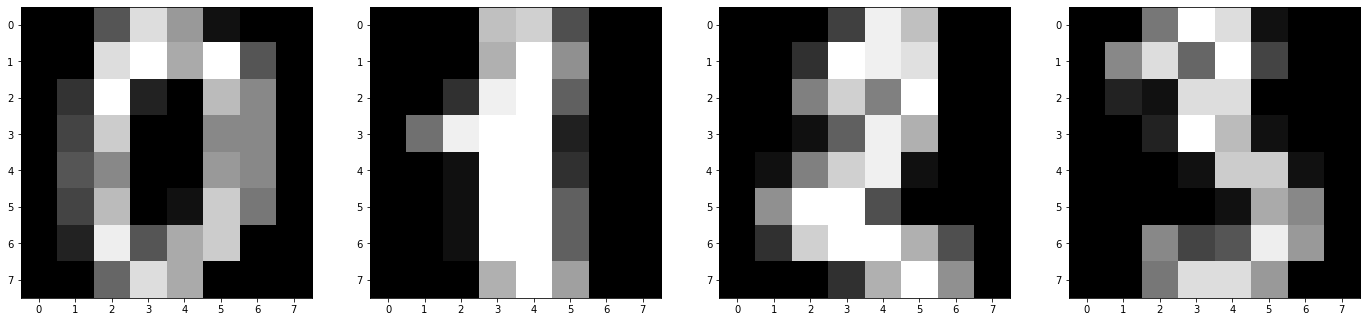

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
ax1.imshow(digits.images[0], cmap='gray')
ax2.imshow(digits.images[1], cmap='gray')
ax3.imshow(digits.images[2], cmap='gray')
ax4.imshow(digits.images[3], cmap='gray')

In [ ]:
def normalize(X_in, a=0, b=1):
    # normalising from [X_min, X_max] to [a, b]
    # task : implement a function that gets X_in as vector/matrix and returns X_out in a desired range
    # hint : all functions you need are min - np.min(X_in), max - np.max(X_in)
    return (b - a) * (X_in - np.min(X_in)) / (np.max(X_in) - np.min(X_in)) + a

In [ ]:
mask = y < 2
X_train, X_test, y_train, y_test = train_test_split(normalize(X[mask]), y[mask], test_size=0.2, random_state=42)

# Cats and dogs dataset

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jM6FPtWf3rmsfyFTOrPNOgHMkzhAIT8b" -O cats_and_dogs.zip && rm -rf /tmp/cookies.txt

In [ ]:
!unzip -q cats_and_dogs.zip

In [ ]:
cats_train_dir = os.path.join('training_set', 'training_set', 'cats')
dogs_train_dir = os.path.join('training_set', 'training_set', 'dogs')

cats_train_fnames = list([os.path.join(cats_train_dir, fname) for fname in os.listdir(cats_train_dir)])
dogs_train_fnames = list([os.path.join(dogs_train_dir, fname) for fname in os.listdir(dogs_train_dir)])

train_fnames = np.random.permutation(cats_train_fnames + dogs_train_fnames)

In [ ]:
cats_test_dir = os.path.join('test_set', 'test_set', 'cats')
dogs_test_dir = os.path.join('test_set', 'test_set', 'dogs')

cats_test_fnames = list([os.path.join(cats_test_dir, fname) for fname in os.listdir(cats_test_dir)])
dogs_test_fnames = list([os.path.join(dogs_test_dir, fname) for fname in os.listdir(dogs_test_dir)])

test_fnames = np.random.permutation(cats_test_fnames + dogs_test_fnames)

In [ ]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    try:
        result = cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    except:
        result = None
    return result

In [ ]:
def prep_data(images):
    """
    Returns:
        X(n_x, m)
        y(1, m) -- 1: dog, 0: cat
    """
    m = len(images)
    n_x = ROWS * COLS * CHANNELS
    
    X = list()
    y = list()
    # print ("X shape is {}".format(X.shape))
    
    for i in tqdm(range(len(images))):
        image_file = images[i]
        image = read_image(image_file)
        if image is not None:
            X.append(np.squeeze(image.reshape((n_x, 1))))
            if 'dog' in image_file.lower():
                y.append(1)
            elif 'cat' in image_file.lower():
                y.append(-1)
            else:# if neither dog nor cat exist, return the image index (this is the case for test data)
                y.append(0)
        # if i%1000 == 0: print('Processed {} of {}'.format(i, m))
    
    X = np.array(X)
    y = np.array(y)
    print ("X shape is {}".format(X.shape))

    return X, y

In [ ]:
cv2_imshow(read_image(test_fnames[40]))

In [ ]:
X_train, y_train = prep_data(train_fnames)

In [ ]:
X_test, y_test = prep_data(test_fnames)

In [ ]:
def margin(y_in, X_in, w):
    # task : implement margin function described above
    # hint 1 : np.dot - for scalar product and matrix multiplication
    # hint 2 : * - Adamar product
    return y_in * np.dot(X_in, w)

In [ ]:
def sigmoid(M):
    # task : implement sigmoid function described above
    return 1 / (1 + np.exp(-M))

In [ ]:
def loss(M):
    # task : implement logistic regression loss function
    # hint 1 : log(a) = np.log(a)
    # hint 2 : sum(arr) = np.sum(arr)
    return np.mean(np.log(1 + np.exp(-M)))

In [ ]:
def p(X_in, w):
    # task : implement probability function described above
    # hint 1 : np.dot - for scalar product and matrix multiplication
    # hint 2 : e^a = np.exp(a)
    return 1 / (1 + np.exp( - np.dot(X_in, w)))

In [ ]:
def predict(X_in, w, a=0.5):
    # task : implement the prediction function
    # hint : p+ is implemented above
    c = p(X_in, w)
    c[c >= a] = 1
    c[c < a] = -1
    return c

In [ ]:
def Loss_grad(w):
    # task : calculate the gradient of loss function defined above
    M = margin(y_train, X_train, w)
    # grad = np.zeros(w.shape)
    y_ = np.tile(y_train, (w.shape[0], 1)).T
    M_ = np.tile(M, (w.shape[0], 1)).T
    return np.mean((1-sigmoid(M_)) * y_ * X_train, axis=0)

In [ ]:
def TP(y_pred, y_true):
    return np.sum(y_pred[y_pred == 1] == y_true[y_pred == 1])

def TN(y_pred, y_true):
    return np.sum(y_pred[y_pred == -1] == y_true[y_pred == -1])

def FP(y_pred, y_true):
    return np.sum(y_pred[y_pred == 1] != y_true[y_pred == 1])

def FN(y_pred, y_true):
    return np.sum(y_pred[y_pred == -1] != y_true[y_pred == -1])

def TPR(y_pred, y_true):
    if TP(y_pred, y_true) + FN(y_pred, y_true) > 0:
        return TP(y_pred, y_true) / (TP(y_pred, y_true) + FN(y_pred, y_true))
    else:
        return 0

def FPR(y_pred, y_true):
    if FP(y_pred, y_true) + TN(y_pred, y_true) > 0:
        return FP(y_pred, y_true) / (FP(y_pred, y_true) + TN(y_pred, y_true))
    else:
        return 0

In [ ]:
def roc_curve(X_in, w_in, y_in, n_points=100):
    x_fpr = list()
    y_tpr = list()
    A = np.linspace(0, 1, n_points)
    for a in A[::-1]:
        y_pred = predict(X_in, w_in, a=a)
        x_fpr.append(FPR(y_pred, y_in))
        y_tpr.append(TPR(y_pred, y_in))
    return np.array(x_fpr), np.array(y_tpr)

NameError: ignored